In [1]:
import numpy as np
import tensorflow as tf

In [2]:
batch_size = 32
num_stocks = 31
seq_len = 10
num_features = 10
num_market_features = num_features

beta = 10.01
units = 64
ft_dim = 32
n_heads = 12

In [7]:
from tensorflow.python.keras.layers import Layer, Dense, LSTM, Dropout, LayerNormalization, Input
from tensorflow.python.keras.models import Model
class FeatureTransformation(Layer):
    def __init__(self, ft_dim):
        super(FeatureTransformation, self).__init__()
        self.ft_dim = ft_dim

    def build(self, input_shape):
        self.ft_linear = Dense(self.ft_dim,
                               input_shape=input_shape,
                               kernel_initializer='glorot_uniform',
                               bias_initializer='glorot_uniform',
                               activation='tanh')

    def call(self, inputs, *args, **kwargs):
        x = tf.reshape(inputs, shape=(-1, inputs.shape[2], inputs.shape[3]))
        x = self.ft_linear(x)
        return x

    def get_config(self):
        config = super().get_config().copy()
        config.update({'ft_dim': self.ft_dim})
        return config


class AttentionLSTM(Layer):
    def __init__(self, units, num_stocks):
        super(AttentionLSTM, self).__init__()
        self.units = units
        self.num_stocks = num_stocks

    def build(self, input_shape):
        self.lstm = LSTM(self.units, return_sequences=True, return_state=False)

    def call(self, inputs, *args, **kwargs):
        feature = self.lstm(inputs)
        attn = tf.matmul(feature, feature[:,-1:,:], transpose_b=True)
        attn = tf.nn.softmax(attn, axis=-1)

        attn = tf.reshape(attn, shape=(-1, self.num_stocks, attn.shape[1], attn.shape[2]))
        feature = tf.reshape(feature, shape=(-1, self.num_stocks, feature.shape[1], feature.shape[2]))
        context = tf.reduce_sum(attn*feature, axis=2)
        return context

    def get_config(self):
        config = super().get_config().copy()
        config.update({'units': self.units,
                       'num_stocks:':self.num_stocks})
        return config


class ContextNormalize(Layer):
    def __init__(self):
        super(ContextNormalize, self).__init__()

    def build(self, input_shape):
        shape = input_shape[1:]
        self.norm_weight = self.add_weight(name='norm_weight',
                                           shape=shape,
                                           initializer='uniform',
                                           trainable=True)

        self.norm_bias = self.add_weight(name='norm_bias',
                                         shape=shape,
                                         initializer='uniform',
                                         trainable=True)

    def call(self, context, *args, **kwargs):
        context = (context - tf.math.reduce_mean(context))/tf.math.reduce_std(context)
        context = self.norm_weight*context+self.norm_bias
        return context

    def get_config(self):
        config = super(ContextNormalize, self).get_config().copy()
        return config


class MultiLevelAggregator(Layer):
    def __init__(self, beta):
        super(MultiLevelAggregator, self).__init__()
        self.beta = beta

    def call(self, inputs, *args, **kwargs):
        stocks_context = inputs[0]
        market_context = inputs[1]
        multi_context = stocks_context + self.beta*market_context
        multi_context = tf.matmul(multi_context, multi_context, transpose_b=True)
        return multi_context

    def get_config(self):
        config = super(MultiLevelAggregator, self).get_config().copy()
        config.update({'beta':self.beta})
        return config


class SingleAttention(Layer):
    def __init__(self):
        super(SingleAttention, self).__init__()

    def build(self, input_shape):
        self.hidden_shape = input_shape[0][-1]
        self.query = Dense(self.hidden_shape,
                           name='query_weight',
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')
        self.key = Dense(self.hidden_shape,
                         name='key_weight',
                         input_shape=input_shape,
                         kernel_initializer='glorot_uniform',
                         bias_initializer='glorot_uniform')
        self.value = Dense(self.hidden_shape,
                           name='value_weight',
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')

    def call(self, inputs, *args, **kwargs):
        q = self.query(inputs[0])
        k = self.key(inputs[1])
        v = self.value(inputs[2])

        attn_weight = tf.matmul(q, k, transpose_b=True)
        attn_weight = tf.map_fn(lambda x: x/np.sqrt(self.hidden_shape), attn_weight)
        attn_weight = tf.nn.softmax(attn_weight, axis=-1)
        attn_weight = tf.matmul(attn_weight, v)
        return attn_weight


class MultiAttention(Layer):
    def __init__(self, n_heads):
        super(MultiAttention, self).__init__()
        self.n_heads = n_heads

    def build(self, input_shape):
        self.attn_heads = [SingleAttention() for i in range(self.n_heads)]
        self.linear = Dense(input_shape[0][-1],
                            name='multi_attn_linear',
                            input_shape=input_shape,
                            kernel_initializer='glorot_uniform',
                            bias_initializer='glorot_uniform')

    def call(self, inputs, *args, **kwargs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        attn = tf.concat(attn, axis=-1)
        attn = self.linear(attn)
        return attn

    def get_config(self):
        config = super(MultiAttention, self).get_config().copy()
        config.update({'n_heads':self.n_heads})
        return config


class NonlinearPrediction(Layer):
    def __init__(self):
        super(NonlinearPrediction, self).__init__()

    def build(self, input_shape):
        self.hidden_size = input_shape[0][-1]
        self.mlp_linear1 = Dense(4*self.hidden_size,
                                 name='mlp_linear1',
                                 input_shape=input_shape,
                                 kernel_initializer='glorot_uniform',
                                 bias_initializer='glorot_uniform')

        self.mlp_linear2 = Dense(self.hidden_size,
                                 name='mlp_linear2',
                                 kernel_initializer='glorot_uniform',
                                 bias_initializer='glorot_uniform')

        self.dropout = Dropout(0.15)
        self.layer_norm = LayerNormalization(input_shape=input_shape,
                                             epsilon=1e-6)

        self.pred_linear = Dense(1,
                                 name='pred_linear',
                                 input_shape=input_shape,
                                 kernel_initializer='glorot_uniform',
                                 bias_initializer='glorot_uniform',
                                 kernel_regularizer='l2',
                                 bias_regularizer='l2',
                                 activation='sigmoid')

    def call(self, inputs, *args, **kwargs):
        context, attn_weights = inputs[0], inputs[1]
        residual_context = context + attn_weights

        mlp_context = self.mlp_linear1(residual_context)
        mlp_context = self.mlp_linear2(mlp_context)

        residual_context = tf.nn.tanh(residual_context + mlp_context)
        residual_context = self.dropout(residual_context)
        residual_context = self.layer_norm(residual_context)

        output = self.pred_linear(residual_context)
        return output

    def get_config(self):
        config = super(NonlinearPrediction, self).get_config().copy()
        config.update({'hiddn_size':self.hidden_size})
        return config

In [8]:
from keras import backend as K
def mcc(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())

def create_model():
    feature_trans_stock = FeatureTransformation(ft_dim)
    feature_trans_market = FeatureTransformation(ft_dim)
    attn_lstm_stock = AttentionLSTM(units, num_stocks)
    attn_lstm_market = AttentionLSTM(units, 1)
    context_norm_stock = ContextNormalize()
    context_norm_market = ContextNormalize()
    multi_lvl_aggregator = MultiLevelAggregator(beta)
    data_axis_attention = MultiAttention(n_heads)
    dropout = Dropout(0.15)
    layer_norm = LayerNormalization(epsilon=1e-6)
    nonlinear_pred = NonlinearPrediction()

    stock_inputs = Input(shape=(num_stocks, seq_len, num_features))
    market_inputs = Input(shape=(1, seq_len, num_market_features))

    stock_features = feature_trans_stock(stock_inputs)
    market_features = feature_trans_market(market_inputs)
    stock_attn = context_norm_stock(attn_lstm_stock(stock_features))
    market_attn = context_norm_market(attn_lstm_market(market_features))

    context = multi_lvl_aggregator([stock_attn, market_attn])

    attn_weight = data_axis_attention((context, context, context))
    attn_weight = dropout(attn_weight)
    attn_weight = layer_norm(attn_weight)
    output = nonlinear_pred([context, attn_weight])

    model = Model(inputs=[stock_inputs, market_inputs], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', mcc])
    return model

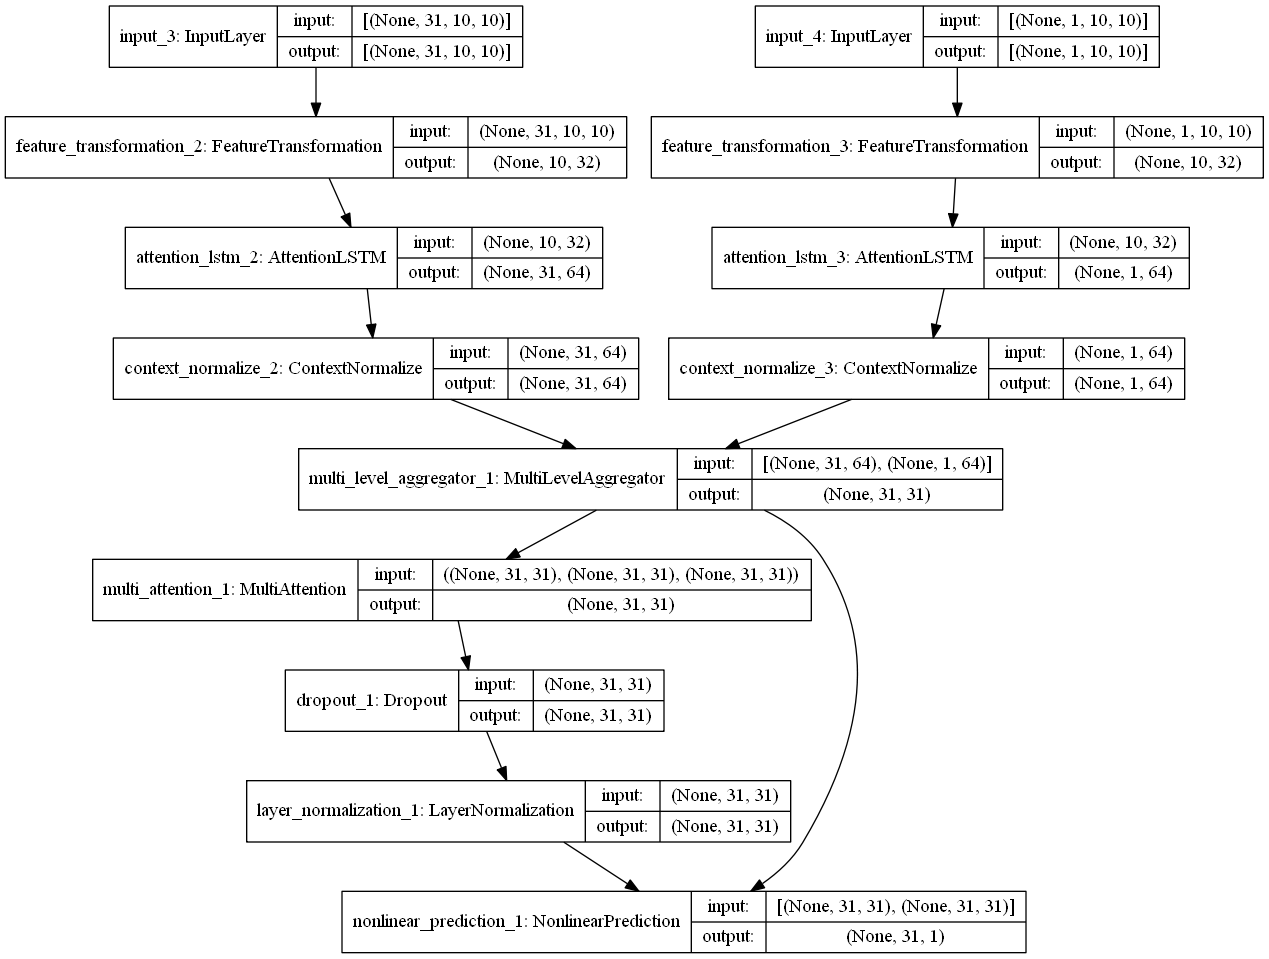

In [9]:
from tensorflow.python.keras.utils.vis_utils import plot_model
model = create_model()
plot_model(model, show_shapes=True, show_layer_names=True)

In [9]:
import os
from bluesunb.preprocessing.kospi_preprocessing import prepare_data
path = os.path.abspath('../data/preprocessed_kospi31_daily_stock_chart.csv')
option = {
    'window_size':seq_len,
    'test_pct':0.2,
    'valid_pct':0.2
}
market_data, stock_data = prepare_data(path, **option)
(X_train_m, y_train_m), (X_valid_m, y_valid_m), (X_test_m, y_test_m) = market_data
(X_train_s, y_train_s), (X_valid_s, y_valid_s), (X_test_s, y_test_s) = stock_data

31


C:\Users\bluesun\anaconda3\envs\rl\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('dtml.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit(x=(X_train_s, X_train_m), y=y_train_s, epochs=100,
                    validation_data=((X_valid_s, X_valid_m), y_valid_s),
                    callbacks=[es, mc])